# Introduction
Welcome to endoSeg, a tool for segmenting fluorescent microscopy images to extract intensity data from outlined regions of interest. The following functions and tools will allow you to load a specified czi file and mask data to perform a segmentation. Depending on the data types the outputs will be either graphs of fluorescent intensity over time or over the lengths of cells. The functions make extensive use of the sci-kit image library for various important functions. 

In [1]:
# First import all of the relevant libraries
from math import factorial
import czifile as cz
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.ndimage as ndi
from skimage import io
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import watershed, clear_border
from skimage.measure import label, regionprops, find_contours
from skimage.morphology import erosion, closing, dilation, disk, square, remove_small_objects, remove_small_holes, skeletonize
from skimage.feature import peak_local_max
from skimage.transform import rotate, resize
from skimage.filters import threshold_otsu, median
from lmfit import Minimizer, Parameters, report_fit
import os as os
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sys import getsizeof

# 1. Define basic functions
This section will be definitions of some basic functions used to handle image data. This includes reading data from czi files, normalising image data and inverting.


In [2]:
def convertToNpy(filename):
    """Converts a CZI file to np array format."""
    #with cz.CziFile(filename) as czi:
    #    image_arrays = czi.asarray()
    image_arrays = cz.imread(filename)
    return image_arrays


def normalize(x, factor=256):
    """Normalize an image to go from 0 to factor"""
    y = (x - x.min()) / (x.max() - x.min()) * factor
    return y


def invert(x):
    """Invert the constrast of an image."""
    y = - (x - x.max())
    return y


def rollingAverage(a, n):
    """Calculates the rolling average of an array a with a step size n."""
    out_av = np.cumsum(a, dtype=float)
    out_av[n:] = out_av[n:] - out_av[:-n]
    return out_av[n-1:] / n


def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques."""             
    try:
      window_size = np.abs(int(window_size))
      order = np.abs(int(order))
    except ValueError:
      raise ValueError("window_size and order have to be of type int")

    if window_size % 2 != 1 or window_size < 1:
      raise TypeError("window_size size must be a positive odd number")

    if window_size < order + 2:
      raise TypeError("window_size is too small for the polynomials order")

    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))

    return np.convolve( m[::-1], y, mode='valid')


def smoothByConvolve(y, kernal_size, window):
    """Calculates a smooth version of a function by convolving with a specified 
       kernal type ('flat', 'hanning', 'hamming', 'bartlett', 'blackman'). Kernal 
       size should be odd."""
    kern = np.r_[y[kernal_size-1:0:-1],y,y[-2:-kernal_size-1:-1]]
    print(len(kern))
    w=eval('np.'+window+'(kernal_size)')
    print(len(w))
    y_smooth = np.convolve(w/w.sum(), kern, mode='same')
    return y_smooth


def smooth_by_convolve(y, kernal_size):
    """Calculates a smooth version of a function by convolving with a linear
       kernal"""
    kern = np.ones(kernal_size)/kernal_size
    y_smooth = np.convolve(y, kern, mode='same')
    return y_smooth


def medianFilter(sigIn):
  """Subtracts the median value of the input signal and sets residual negative values to zero"""

  sigOut = sigIn - np.median(sigIn[sigIn > 0])
  sigOut[sigOut < 0] = 0

  return sigOut

In [3]:
class pointSelector:
    """This class allows the retrieval of x and y coordinates from a plot that can be used
    later to retrieve values from particular points in a matrix."""

    def __init__(self, fig=[], ax=[]):
        # Check that a figure actually exists
        if fig == []:
            fig = plt.gcf()

        if ax == []:
            ax = plt.gca()

        # Create holders for the x/y coordinates
        self.allxpoints = []
        self.allypoints = []
        self.fig = fig
        self.ax = ax

        self.__ID2 = self.fig.canvas.mpl_connect(
            'button_press_event', self.__onClick)

        plt.show()


    def __onClick(self, event):

        if event.button == 1:
            # Check if a region has been clicked and store the coordinates
            x, y = np.round(event.xdata), np.round(event.ydata)
            self.allxpoints.append(int(x))
            self.allypoints.append(int(y))
            self.ax.scatter(self.allxpoints,self.allypoints,marker='x', color='r')
            self.fig.canvas.draw()
        # Right click will close the figure
        elif event.button == 3:
            plt.close(self.fig)


def selectBadSegments(segmentationResult, segmentOverlay):
    """This function accounts for the fact the segmentation will be imperfect 
       due to some cells not being completely in the FOV or the nuclei of some 
       cells not being in the FOV."""

    fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
    ax.imshow(segmentOverlay)
    ax.set_title('Left click to select a cell, right click to close')
    Points = pointSelector(fig, ax)
    #print(Points.allxpoints, Points.allypoints)

    badLabels = []
    for ii in range(0, len(Points.allxpoints)):
        badLabels.append(segmentationResult[Points.allypoints[ii],
                          Points.allxpoints[ii]])

   
    return badLabels


In [4]:
# This section of code is not super essential but it helps make figures more
# customizable.

# Define figure axis font sizes\
plt.style.use('seaborn-muted')
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/tmp/ipykernel_852493/4108163520.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


# 2. Initialization
This section is used to define parameters that are essential to the analysis such as the paths to the image and mask data, the image pixel size and the time per frame (for time series). 

In [19]:
data_path = '/ceph/users/gbp79325/PROJECTS/endoSeg/data/PTRF_Quantification/'
path_2_czi = data_path + 'PTRF_alpha-tubulin_ZO-1_DAPI_20x_HF_confocal_zstack_OP_2.czi'   # location of image data 
path_2_mask = data_path + 'PTRF_alpha-tubulin_ZO-1_DAPI_20x_HF_confocal_zstack_OP_2_mask.png' # location of mask image
pixel_size = 0.55  # size of 1 pixel (in µm)
time_stamp = 1  # exposure time per frame (in seconds)
output_path = '/ceph/users/gbp79325/PROJECTS/endoSeg/results/PTRF_alpha-tubulin_ZO-1_DAPI_20x_HF_confocal_zstack_OP_2/' # Path to output results
try:
  os.makedirs(output_path)
except OSError:
  if not os.path.isdir(output_path):
    raise

# 3. Segmentation
In this section we will use the mask data to define the regions in the sample that correspond to cells. The assumptions being made are that the borders are contiguous and provided as an rgb image. Cells are segmented by simple thresholding followed by some basic morphological image processing and a final watershed.

In [6]:
def borderCleanUp(file_name):
  """This function is used to clean up the predicted borders from machine learning 
     for use in later segmentation."""
  mask_data = io.imread(file_name)
  mask_data = rgb2gray(mask_data[:,:,0:3])
  #mask_data = resize(mask_data, (1024, 1024))
  #mask_data = invert(mask_data)
  #selem = disk(30)
  thresh = threshold_otsu(mask_data)
  bin_mask = mask_data > thresh
  trimmed_mask_data = remove_small_holes(bin_mask, 20)
  trimmed_mask_data = remove_small_objects(trimmed_mask_data, min_size=50) #white_tophat(mask_data, selem)
  skeleton = trimmed_mask_data

  f, ax = plt.subplots(2, 2, figsize=(15, 15), dpi=300)
  ax[0, 0].imshow(mask_data, interpolation='none', cmap='Greys')
  ax[0, 1].imshow(invert(1*bin_mask), interpolation='none', cmap='Greys')
  ax[1, 0].imshow(trimmed_mask_data, interpolation='none', cmap='Greys')
  ax[1, 1].imshow(skeleton, interpolation='none', cmap='Greys')
  plt.show()
  print(type(trimmed_mask_data), type(skeleton))
  return bin_mask, trimmed_mask_data, skeleton


In [7]:
def segmentNucleus(nucleus_image):
  """This function is used to segment DAPI labeled Nuclei from multichannel
     fluoresence data using simple morphological operations. The output is
     both the binary nucleus image (for removing nuclear signal) and the 
     labelled nuclei."""

  thresh = threshold_otsu(nucleus_image)
  bw = closing(nucleus_image > thresh, square(4))
  cleared = remove_small_objects(clear_border(bw), 150)
  nuc_labels = label(cleared)
  
  return cleared, nuc_labels


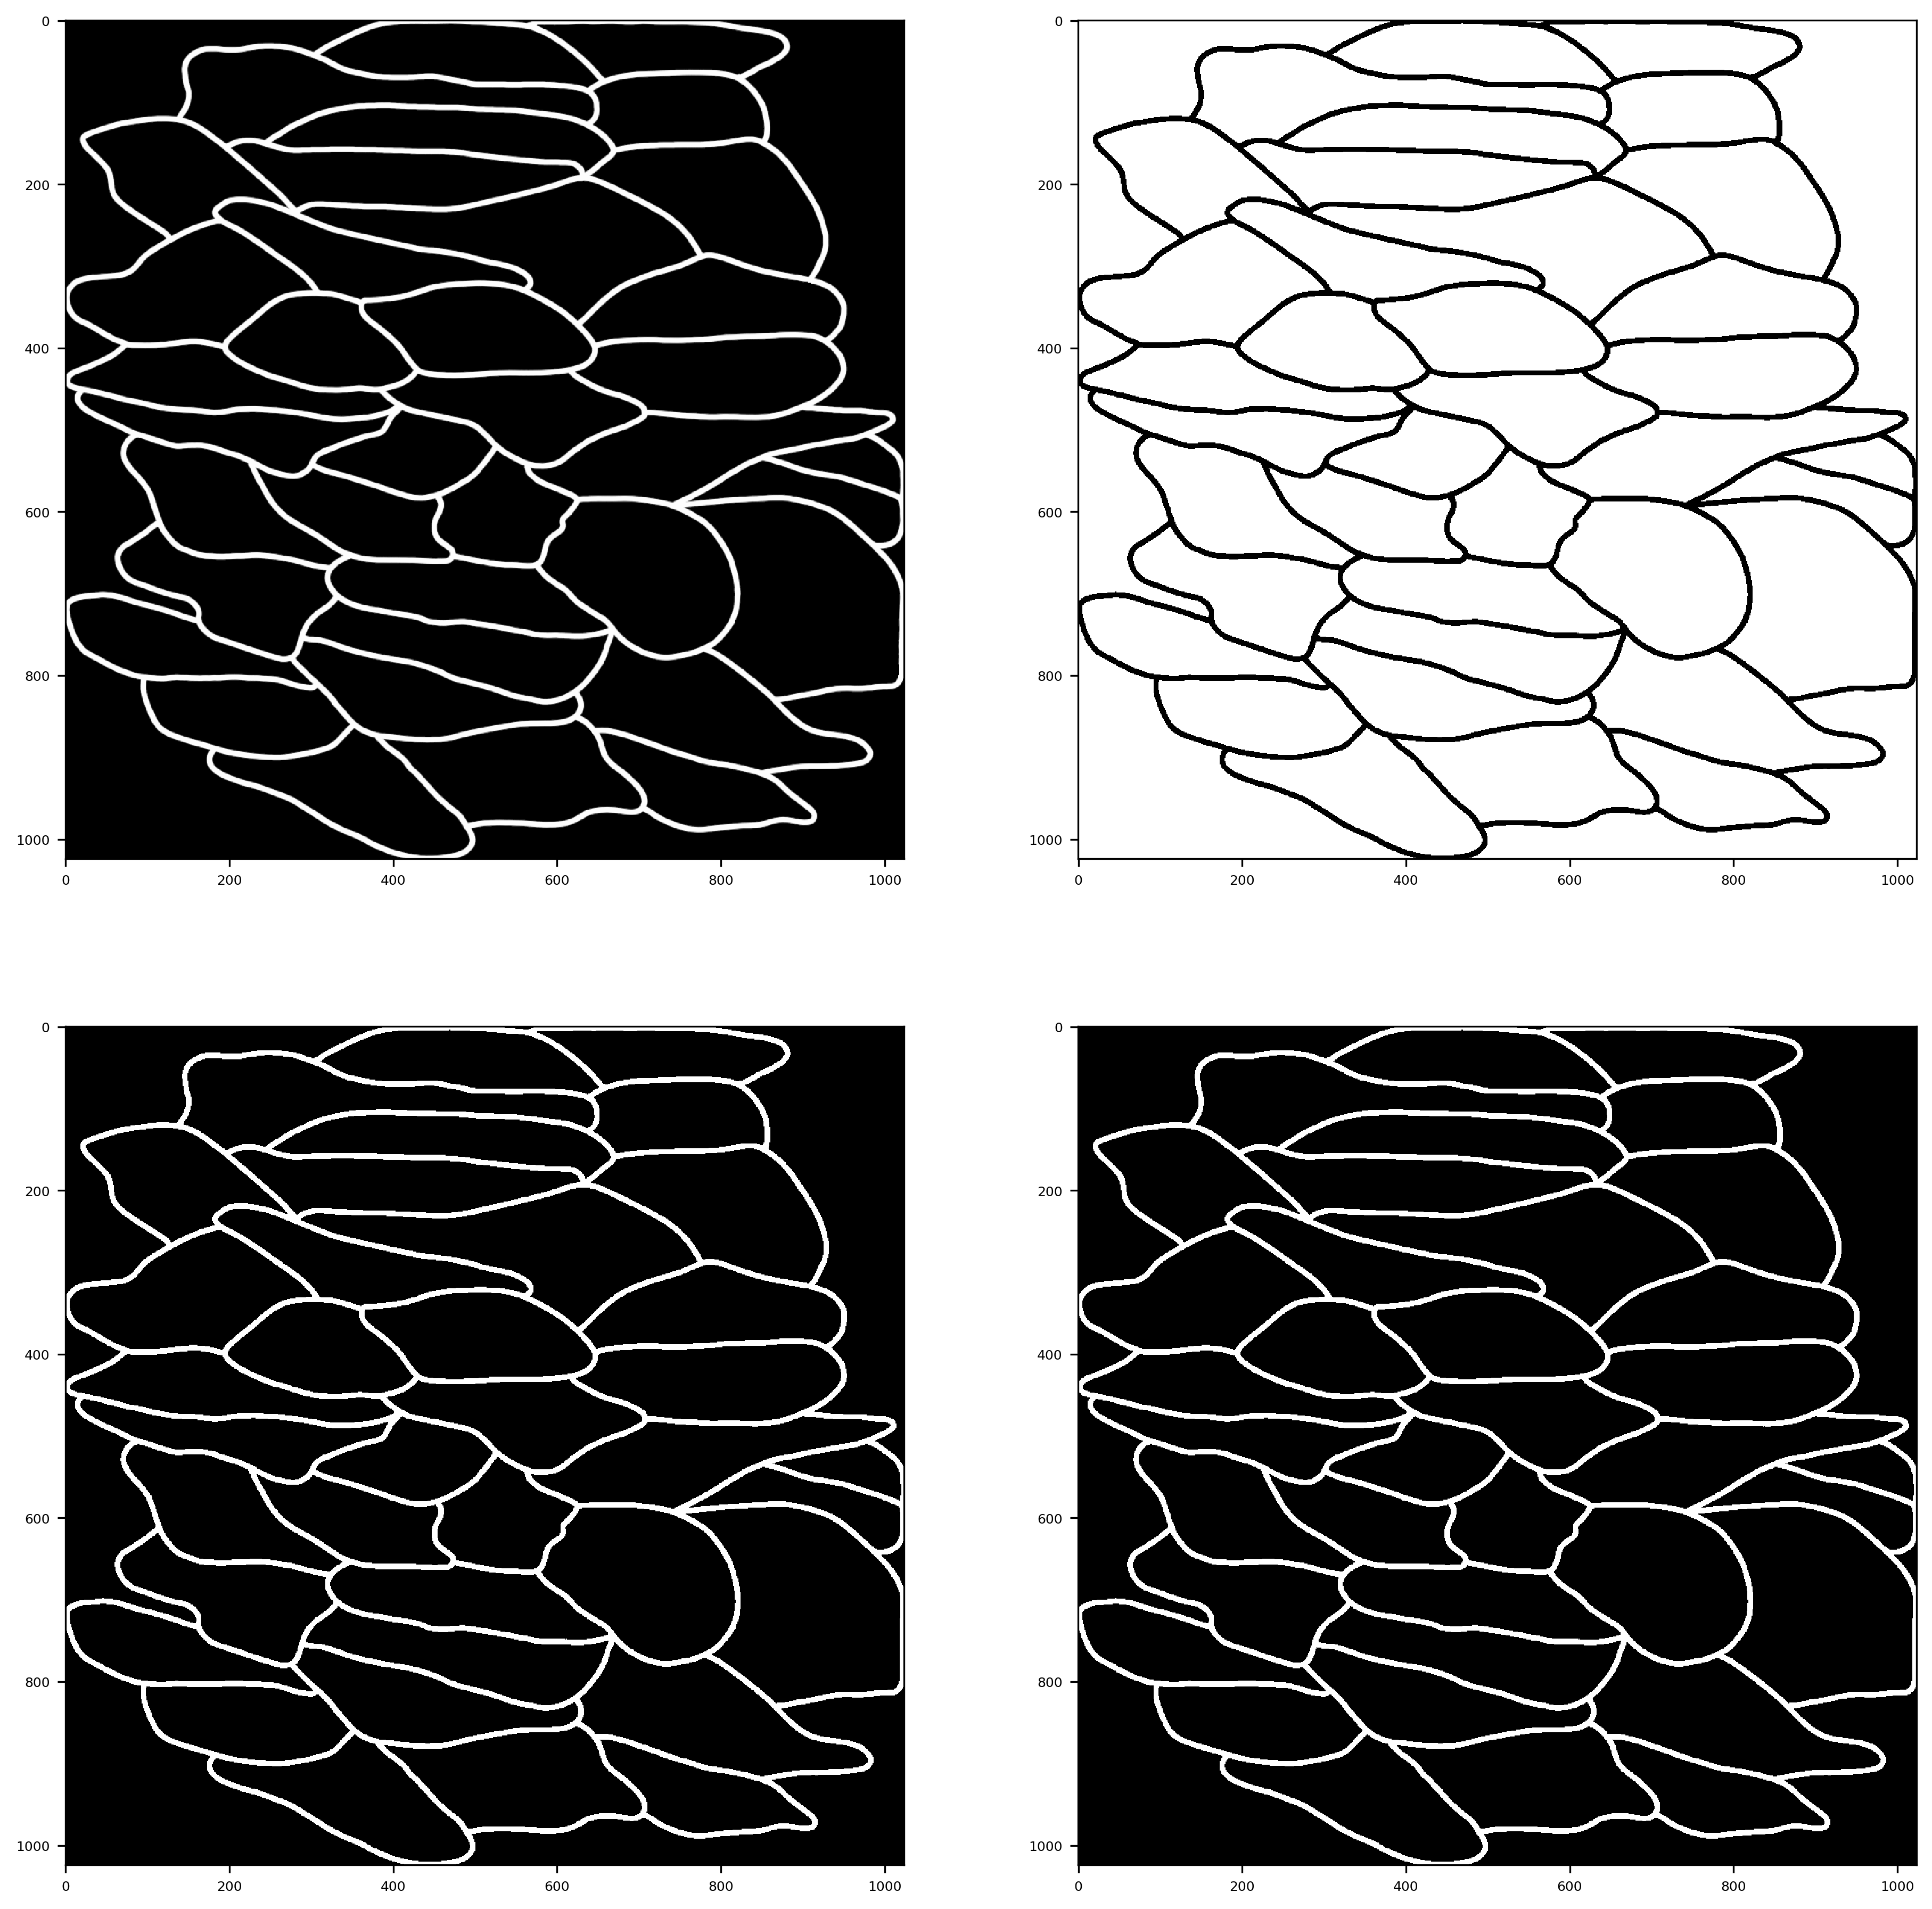

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [21]:
cell_outlines, test_mask, skeleton = borderCleanUp(path_2_mask)

czi file detected

(4, 1024, 1024)
(4, 1024, 1024)
(1024, 1024, 4)
1048576
45


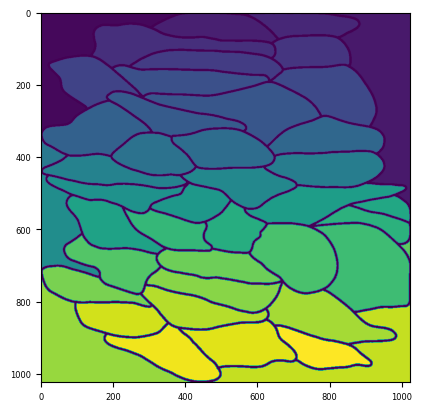

In [22]:
# Load in the fluorescent images and mask data
if path_2_czi.split('.')[-1] == 'czi':
    print('czi file detected\n')
    calcium_data = np.squeeze(convertToNpy(path_2_czi))
    print(calcium_data.shape)
    if len(calcium_data.shape) > 3:
        calcium_data = np.squeeze(np.max(calcium_data,1))
        print(len(calcium_data.shape))

elif path_2_czi.split('.')[-1] == 'tif':
    calcium_data = io.imread(path_2_czi,plugin="tifffile")
    print('tif detected\n')
else:
    calcium_data = io.imread(path_2_czi)
  #print(' Input file not recognized\n')

print(calcium_data.shape)
mask_data = io.imread(path_2_mask)
print(mask_data.shape)

# Use otsu threshold, inversion and dilation/erosion to create
# centres for initial segmentation
mask_data = rgb2gray(mask_data[:,:,0:3])
#test_mask = resize(test_mask, (1242, 1298))
thresh = threshold_otsu(mask_data)
bin_mask = mask_data > thresh
#borders = np.array(invert(1*test_mask)) # This version for ML trimmed data
#borders = np.array(bin_mask)
#bin_mask = dilation(bin_mask, disk(1))
#test_mask = np.rot90(np.fliplr(test_mask),2)
borders = test_mask # This version for ML trimmed data
bin_mask = invert(1*test_mask)
#res = white_tophat(bin_mask, disk(5))
#bin_mask = bin_mask - res
cell_labels = ndi.label(borders)[0]
plt.imshow(cell_labels)
plt.show
print(cell_labels.size)
ws_seg = watershed(bin_mask, cell_labels, mask=borders)
print(ws_seg.max())
# Grab the centroids of the cells and create segmentation figure
all_centx = []
all_centy = []
all_ids = []
cell_region_props = regionprops(ws_seg)
for region in cell_region_props:
    centY, centX = region.centroid
    all_centx.append(centX)
    all_centy.append(centY)
    all_ids.append(str(ws_seg[int(centY), int(centX)]))


#badLabels = selectBadSegments(ws_seg, imageLabelOverlay)




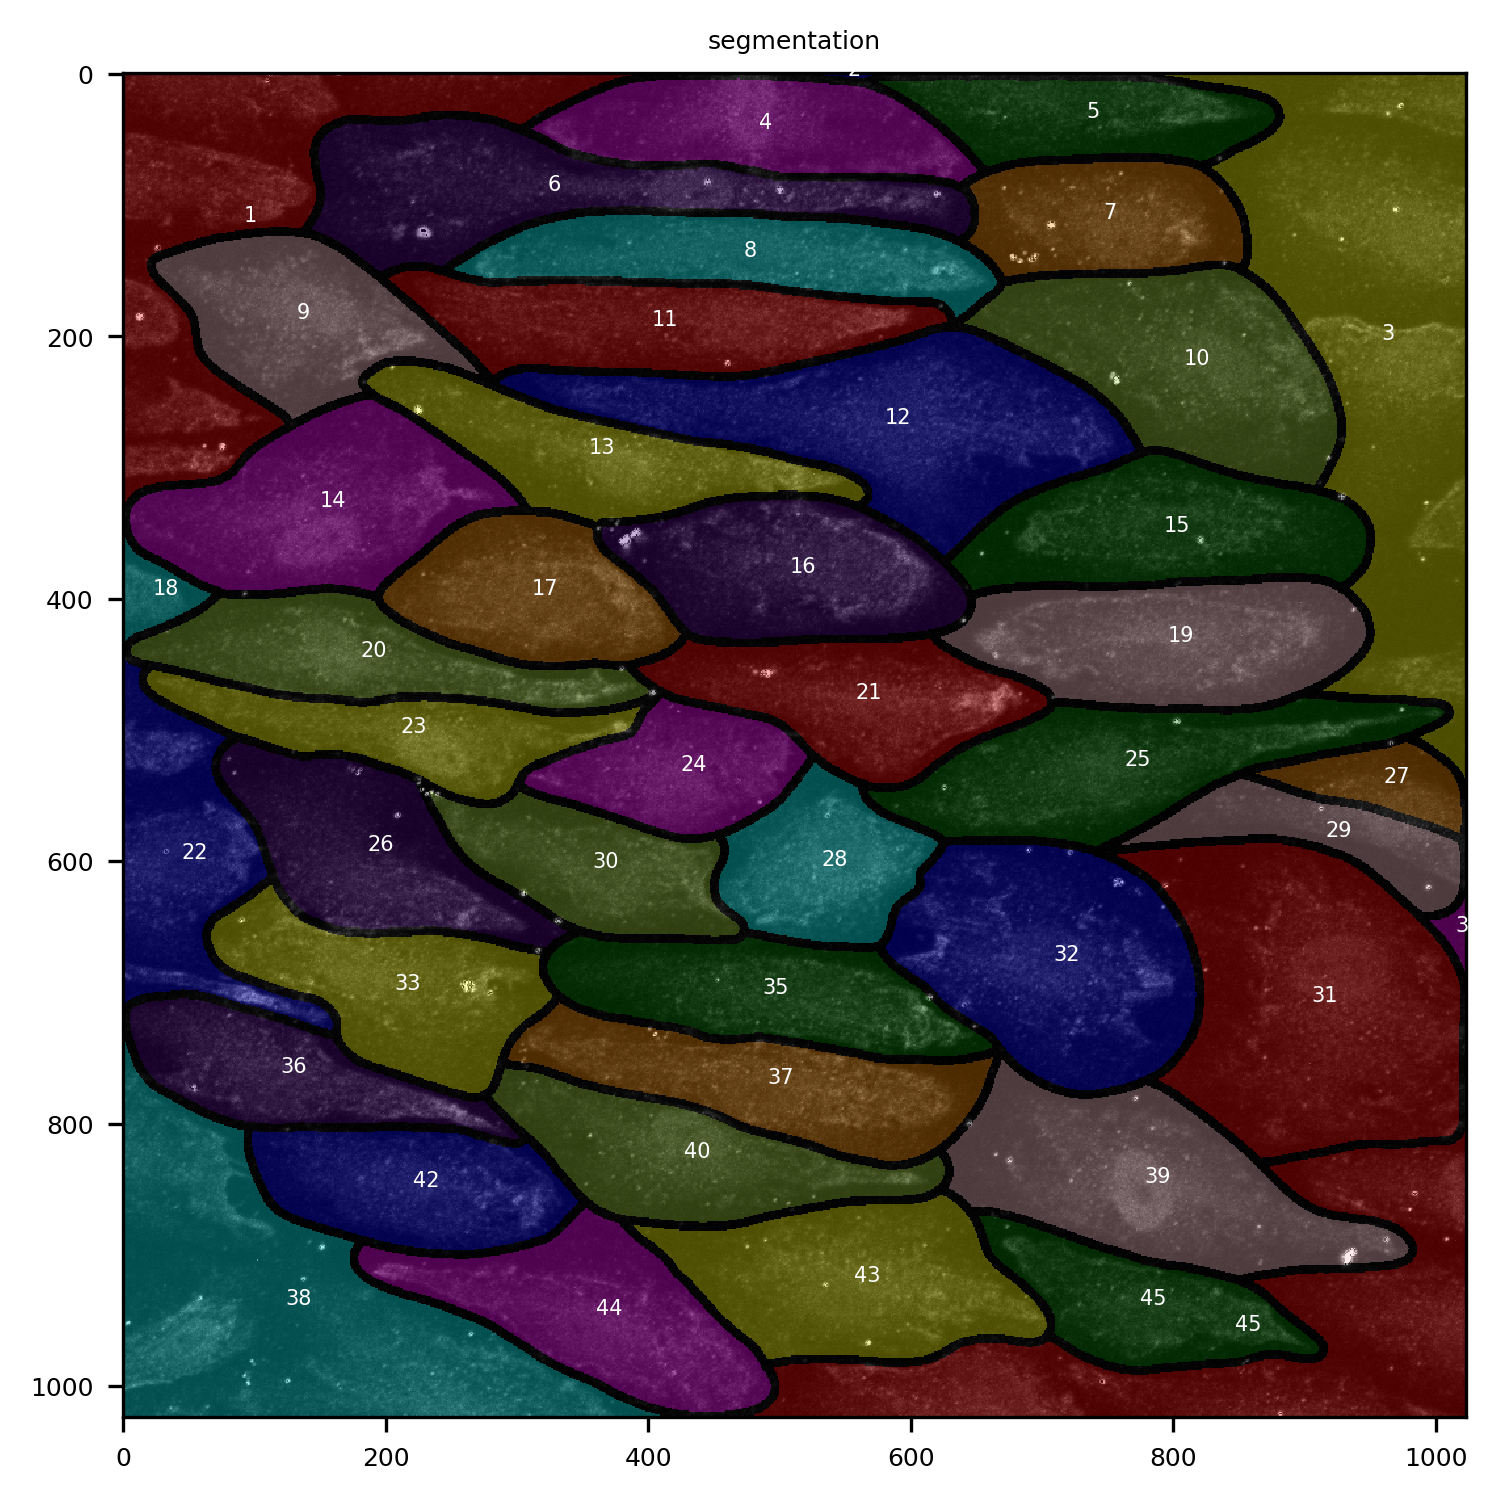

In [23]:
imageLabelOverlay = label2rgb(ws_seg, calcium_data[0,:, :]*2, bg_label=0)
f, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
ax.imshow(imageLabelOverlay, interpolation='none')
for i, txt in enumerate(all_ids):
    ax.annotate(txt, (all_centx[i], all_centy[i]), color='white', size=5)
ax.set_title('segmentation')
plt.tight_layout()
plt.savefig(output_path + 'Segmentation_result.png')
plt.close()

f, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
ax.imshow(imageLabelOverlay, interpolation='none')
for i, txt in enumerate(all_ids):
    ax.annotate(txt, (all_centx[i], all_centy[i]), color='white', size=5)
ax.set_title('segmentation')
plt.tight_layout()
plt.show()


# 4. Analysis
The final section performs analysis on the segmented cells. To start off several accessory functions need to be defined to handle things like defining to extent of the cell and calculating the fluorescent decay to effectively subtract background from the time series. In this first instance we only consider integrating signal normal to the flow direction, so the predicted orientation of the cell is not take into account.

In [11]:
def residual(params, x, y_hat, eps_data):
    """Residual for calculating an assymetric loss function."""
    amp = params['amp']
    decay = params['decay']
    a = params['a']
    b = params['b']
    #m = params['m']
    c = params['c']

    model = (amp * np.exp(x * decay)) + a * x ** 2 + b * x + c
    dy = (model - y_hat)
    lossFunc = (dy ** 2) * ((np.sign(dy) + 0.8) ** 4) / eps_data

    return lossFunc

def correctDecay(cellSignal, type):

    """Function for fitting a mixed exponential model to calcium signalling data to account for the
       signal loss due to fluoresence decay over time. If fit type is 1 the fit uses an asymmetric 
       loss function to prevent over-fitting the curve to the data. This is to ensure that only the 
       background is subtracted and spikes in calcium signal are preserved. If type is 2 the fit will 
       use a fairly broad guassian kernal to estimate a smoothed background from the data directly."""
    if type == 1:
      y_hat = np.array(cellSignal)
      x = np.arange(0, len(cellSignal))

      params = Parameters()
      params.add('amp', value=20)
      params.add('decay', value=-1)
      params.add('a', value=0.01)
      params.add('b', value=-0.5)
      #params.add('m', value=-0.5)
      params.add('c', value=450)
      eps_data = 1.0

      # do fit, here with leastsq model
      minner = Minimizer(residual, params, fcn_args=(x, y_hat, eps_data), nan_policy='omit')
      try:
        result = minner.minimize(method='leastsq')
        amp = result.params['amp']
        decay = result.params['decay']
        a = result.params['a']
        b = result.params['b']
        #m = result.params['m']
        c = result.params['c']
        #print(amp, decay, a, b, c)
        model = (amp * np.exp(x * decay)) + a * x ** 2 + b * x + c

      except ValueError:
        # Sometimes least squares fails to fit due to NaN. In those cases switch
        # to the Nelder-Mead
        result = minner.minimize(method='nelder')
        amp = result.params['amp']
        decay = result.params['decay']
        a = result.params['a']
        b = result.params['b']
        #m = result.params['m']
        c = result.params['c']
        #print(amp, decay, a, b, c)
        model = (amp * np.exp(x * decay)) + a * x ** 2 + b * x + c
        #model = x + c
        #model = np.median(cellSignal)
        print('fail')
      cellSignal = cellSignal - model
      cellSignal[cellSignal < 0] = 0
    elif type == 2:
      # If least squares is consistently failing use a heavily smoothed curve to
      # estimate the background.
      model = smoothByConvolve(cellSignal, 31, 'hanning')
      cellSignal = cellSignal - model
      cellSignal[cellSignal < 0] = 0
    elif type == 3:
      # Final option for background subtraction is to fit a polynomial to subsets
      # of the curve to calculate a contiguous background
      model = savitzky_golay(cellSignal, 51, 5)
      cellSignal = cellSignal - model
      cellSignal[cellSignal < 0] = 0
    return cellSignal

def calcOrientationMap(cellLabels, cellToAnalyze, xSize, ySize):

    """This function takes in the  the segmentation and uses it to calculate the angle the cell is rotated
       away from the normal. Then, using the  centroid of the cell, it calculates a a distance map from the
       midpoint rotated according to the cells orientation which can be used to quantify protein concentrations 
       at a given distance. cellToAnalyze is an integer."""
       
    # Retrieve the orientations (in radians) of the nuclei from region props
    mask = cellLabels == cellToAnalyze
    cellLabel = label(mask)
    cellRegionProps = regionprops(cellLabel)
    for region in cellRegionProps:
        centY, centX = region.centroid
        rotAngle = region.orientation

    print(centY, centX)

    #if np.pi / 4 < rotAngle <= np.pi * (3 / 4):
    #    rotAngle -= np.pi / 2
    #elif rotAngle > np.pi * (3 / 4):
    #    rotAngle -= np.pi

    rotAngle *= (180/np.pi)
    #if np.abs(rotAngle) >= 70:
    #  rotAngle = np.abs(rotAngle)
    print(str(rotAngle))

    # Calculate distance map rotated so that it is parallel to cell orientation
    yy, xx = np.indices((ySize, xSize))
    xx = xx - np.round(centX)
    yy = yy - np.round(centY)
    # This assumes flow is along the horizontal direction
    orientMap = xx#rotate(yy, rotAngle, center=(centX, centY), order=0)
    #if rotAngle < 0:
    #  if np.abs(rotAngle) < 70:
    #    orientMap *= -1
    #  else:
    #    rotAngle = np.abs(rotAngle)
    #    orientMap = rotate(yy, rotAngle, center=(centX, centY), order=0)


    return orientMap

def getSectorInds(orientMap, sectorSize, downstreamEnd, upstreamEnd):
  
  """This funtion is used to define the indices of a sector or quadrant of the cell
     to perform analysis on. The input is the distance map calculated for a particular
     cell and indRange defines the regions of the map that need to be extracted"""
  downstreamEnd = int(downstreamEnd)
  upstreamEnd = int(upstreamEnd)

  sectorMap = np.zeros_like(orientMap)
  currentSector = 1
  for i in range(downstreamEnd, upstreamEnd+1):
    if i != 0:
      if i <= (downstreamEnd + currentSector*sectorSize):
        sectorMap[orientMap == i] = currentSector
      else:
        currentSector +=1
        sectorMap[orientMap == i] = currentSector

  #plt.imshow(sectorMap)
  #plt.show()
  return sectorMap


In [12]:
def createOutputs(dataType, baseDir, cellLab, ind, allQuads, rawSig, allFrame, 
                  RegionProps, sectorMap, channelName, distances, orientation):
  """This function takes the various pieces of data from the calcium distributuion
     analysis and creates specific outputs that are then dumped in a single directory."""
  ######################### Time series data outputs #########################
  if dataType == 'timeSeries':
    ## Create outputs for single channel time series data

    # Create a cell specific directory
    outputDir = baseDir + 'cell' + str(ind) + '/'
    try:
      os.makedirs(outputDir)
    except OSError: 
      if not os.path.isdir(outputDir):
          raise

    # Extract various parameters about the cell to be output as an excel 
    # spreadsheet using pandas dataframes 

    # First set up the writer
    writer = pd.ExcelWriter(outputDir + 'cellData' + str(ind) + '.xlsx', engine='xlsxwriter')

    #### Modified 2022/09/17 reduced number of sectors to 3, UsTip, Mid, DsTip ####
    # Extract the information from the cell
    for region in RegionProps:
      longAx = region.major_axis_length
      shortAx = region.minor_axis_length
      aspectRatio = longAx/ shortAx
      area = region.area
    
    ### Normalised IoD to whole cell IoD to account for background of dispersion
    IoDWc = np.std(allQuads[3, :])**2/np.mean(allQuads[3, :])
    IoDUsTip = (np.std(allQuads[0, :])**2/np.mean(allQuads[0, :])) / IoDWc
    IoDUsMid = (np.std(allQuads[1, :])**2/np.mean(allQuads[1, :])) / IoDWc
  #  IoDDsMid = np.std(allQuads[2, :])**2/np.mean(allQuads[2, :])
    IoDDsTip = (np.std(allQuads[2, :])**2/np.mean(allQuads[2, :])) / IoDWc


    meanWc = np.mean(allQuads[3, :])
    meanUsTip = np.mean(allQuads[0, :])
    meanUsMid = np.mean(allQuads[1, :])
  #  meanDsMid = np.mean(allQuads[2, :])
    meanDsTip = np.mean(allQuads[2, :])

    # Create a dictionary to contain all of the information and create a dataframe
    propDict = {'cell ID' : ind,
                'area (pixels)' : area,
                'aspect ratio' : aspectRatio,
                'IoD whole cell' : IoDWc,
                'IoD upstream tip' : IoDUsTip,
#                'IoD upstream mid' : IoDUsMid,
                'IoD Mid' : IoDUsMid,
#                'IoD downstream mid' : IoDDsMid,
                'IoD downstream tip' : IoDDsTip,
                'mean whole cell' : meanWc,
                'mean upstream tip' : meanUsTip,
#                'mean upstream mid' : meanUsMid,
                'mean mid' : meanUsMid,
#                'mean downstream mid' : meanDsMid,
                'mean downstream tip' : meanDsTip}

    cellInfo = pd.DataFrame.from_dict([propDict])

    signalDict = {'Whole cell fluorescence': allQuads[3, :],
                  'Upstream tip fluorescence': allQuads[0, :],
#                  'Upstream mid fluorescence': allQuads[1, :],
                  'Midstream fluoresence': allQuads[1,:],
#                  'Downstream mid fluorescence': allQuads[2, :],
                  'Downstream tip fluorescence': allQuads[2, :]}

    rawDict = {'Whole cell fluorescence': rawSig[3, :],
                'Upstream tip fluorescence': rawSig[0, :],
#                'Upstream mid fluorescence': rawSig[1, :],
                'Midstream fluorescence': rawSig[1, :],
#                'Downstream mid fluorescence': rawSig[2, :],
                'Downstream tip fluorescence': rawSig[2, :]}

    # Write dictionaries out as an excel file
    fluoSignal = pd.DataFrame.from_dict(signalDict)
    rawSignal = pd.DataFrame.from_dict(rawDict)

    cellInfo.to_excel(writer, sheet_name = 'celInfo')
    fluoSignal.to_excel(writer, sheet_name = 'fluorescentSignal')
    rawSignal.to_excel(writer, sheet_name = 'rawSignal')
    writer.save()

    # Create a dummy image showing mean fluoresence in each sector of the cell
    upstreamTipInds = np.where(sectorMap == 1)
    upstreamMidInds = np.where(sectorMap == 2)
    #downstreamMidInds = np.where(sectorMap == 3)
    downstreamTipInds = np.where(sectorMap >= 3)

    sectorMap[upstreamTipInds] = meanUsTip
    sectorMap[upstreamMidInds] = meanUsMid
    #sectorMap[downstreamMidInds] = meanDsMid
    sectorMap[downstreamTipInds] = meanDsTip

    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
    fig.set_tight_layout(True)
    im = ax.imshow(sectorMap, cmap=plt.cm.magma)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, label='Mean fluorescent intensity (arb. u.)')
    plt.savefig(outputDir + 'mean_fluoresence_by_sector_cell' + str(ind) + '.png')
    fig.clf()
    plt.close('all')
    gc.collect()

    # Plot the fluorescent signal as a function of frame
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
    fig.set_tight_layout(True)

    ax.plot(allFrame, allQuads[3, :], color='gray', alpha=0.75, label='Whole cell')
    ax.plot(allFrame, allQuads[0, :], color='red', label='Upstream tip')
    ax.plot(allFrame, allQuads[1, :], color='orchid', label='Midstream')
    #ax.plot(allFrame, allQuads[2, :], color='darkviolet', label='Downstream mid')
    ax.plot(allFrame, allQuads[2, :], color='blue', label='Downstream tip')
    ax.set_title('gCamp: Aspect ratio = %.2f ' % (longAx / shortAx))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean fluorescent intensity (arb. u.)')
    ax.legend(loc='upper left', frameon=False)

    plt.savefig(outputDir + 'calcium_distribution_cell' + str(ind) + '.png')
    fig.clf()
    plt.close('all')
    gc.collect()

  ######################### Multi channel data outputs #########################  
  elif dataType == 'multiChannel':
    ## Create the outputs for a multi channel, single time point experiment 
    
    # Create a cell specific directory
    outputDir = baseDir + 'cell' + str(ind) + '/'
    try:
      os.makedirs(outputDir)
    except OSError: 
      if not os.path.isdir(outputDir):
          raise

    # Extract various parameters about the cell to be output as an excel 
    # spreadsheet using pandas dataframes 

    # First set up the writer
    writer = pd.ExcelWriter(outputDir + 'cellData' + str(ind) + channelName + '.xlsx', engine='xlsxwriter')

    # Extract the information from the cell
    for region in RegionProps:
      longAx = region.major_axis_length
      shortAx = region.minor_axis_length
      aspectRatio = longAx/ shortAx
      area = region.area
    cellLab = 1*cellLab  
    border = cellLab - erosion(cellLab, square(3))
    border = skeletonize(border)
    contours = find_contours(border,0.8)
    
    # For multi channel data allQuads already stores the mean value
    # Change to account for only being 3 channels 
    meanWc = allQuads[3]
    meanUsTip = allQuads[0]
    meanUsMid = allQuads[1]
    #meanDsMid = allQuads[2]
    meanDsTip = allQuads[2]

    # For multi channel data rawSig contains the unintegrated quadrant data
    IoDWc = np.std(rawSig[3])**2/np.mean(rawSig[3])
    IoDUsTip = np.std(rawSig[0])**2/np.mean(rawSig[0])
    IoDUsMid = np.std(rawSig[1])**2/np.mean(rawSig[1])
    #IoDDsMid = np.std(rawSig[2])**2/np.mean(rawSig[2])
    IoDDsTip = np.std(rawSig[2])**2/np.mean(rawSig[2])

    # Create a dictionary to contain all of the information and create a dataframe
    propDict = {'cell ID' : ind,
                'area (pixels)' : area,
                'aspect ratio' : aspectRatio,
                'IoD whole cell' : IoDWc,
                'IoD upstream tip' : IoDUsTip,
                'IoD mid' : IoDUsMid,
                #'IoD downstream mid' : IoDDsMid,
                'IoD downstream tip' : IoDDsTip,
                'mean whole cell' : meanWc,
                'mean upstream tip' : meanUsTip,
                'mean mid' : meanUsMid,
                #'mean downstream mid' : meanDsMid,
                'mean downstream tip' : meanDsTip}

    cellInfo = pd.DataFrame.from_dict([propDict])

    rawDict = {'Whole cell fluorescence': np.array(allFrame)}
#                'Upstream tip fluorescence': rawSig[0],
#                'Upstream mid fluorescence': rawSig[1],
#                'Downstream mid fluorescence': rawSig[2],
#                'Downstream tip fluorescence': rawSig[3]}
    rawSignal = pd.DataFrame.from_dict([rawDict])
    
    ## Modified 2021/11/05 for multichannel data just output the masked fluorescent
    ## signal for each channel instead of sectormap

    cellInfo.to_excel(writer, sheet_name = 'celInfo')
    rawSignal.to_excel(writer, sheet_name = 'rawSignal')
    writer.save()
    
        # Plot the fluorescent signal as a function distance from the cell centre
    smooth_fluo_sig = smooth_by_convolve(allFrame, 10)
    fig, ax = plt.subplots(1, 1,figsize=(5, 5), dpi=300)
    fig.set_tight_layout(True)
    ax.plot(distances, allFrame, color='gray', alpha=0.3)
    ax.plot(distances, smooth_fluo_sig, color='red')
    ax.fill_between(distances, allFrame, facecolor='gray', alpha=0.3)
    ax.set_title( channelName + ': Aspect ratio = %.2f ' % aspectRatio)
    ax.set_xlabel('Distance from nucleus (pixel)')
    ax.set_ylabel('Normalized fluorescent intensity (arb. u.)')

    plt.savefig(outputDir + 'protein_distribution_cell' + str(ind) + '_' + 
                channelName + '.png')
    fig.clf()
    plt.close('all')
    gc.collect()

    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
    fig.set_tight_layout(True)
    im = ax.imshow(sectorMap, cmap=plt.cm.magma)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, label='Mean fluorescent intensity (arb. u.)')
    loc = 1
    for contour in contours:
      ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='w')
    
    plt.savefig(outputDir + 'fluoresence_signal_cell' + str(ind) + 
                channelName + '.png')
    fig.clf()
    plt.close('all')
    gc.collect()

    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
    fig.set_tight_layout(True)
    im = ax.imshow(orientation, cmap=plt.cm.magma)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #plt.colorbar(im, cax=cax, label='Mean fluorescent intensity (arb. u.)')
    #loc = 1
    for contour in contours:
      ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='w')
    
    plt.savefig(outputDir + 'orientation_map_cell' + str(ind) + 
                channelName + '.png')
    fig.clf()
    plt.close('all')
    gc.collect()






In [13]:
def calcCalciumDistribution(path2Data, cellLabels, pixelSize, timeStamp, baseDir, 
                            badLabels, badTimePoints, start_end):

    """This function uses a mask from the segmentation to calculate the distribution of calcium
        within the cell based on fluorescent signal over a time series. It display the results as
        a line plot."""

    # Use the median of the image to get an estimate for the pixelwise background
    dataIn = np.squeeze(convertToNpy(path2Data))
    zz, yy, xx = dataIn.shape
    print(zz)
    #zz = 235 # Only analyse the first 235 frames
    #backgroundIm = np.mean(dataIn, 0)
    #bkgMax = np.max(backgroundIm)
    #backgroundIm = median(normalize(backgroundIm, 1.0), square(5))
    #backgroundIm = normalize(backgroundIm, bkgMax)
    tracemalloc.start()
    # Set up containers for various statistic about the cell
    allAspect = []
    allIoD = []
    allIoDUs = []
    allIoDUsM = []
    allIoDDsM = []
    allIoDDs = []
    allMax = []
    allMean = []
    allArea = []
    allID = []
    allSpike = []
    allSpikeLoc = []

    # loop through all the time series and extract fluoresence data
    # Background should be index 0
    for ind in range(1, np.max(cellLabels) + 1):
      snapshot1 = tracemalloc.take_snapshot()
      if ind not in badLabels:
        print('='*10 + 'Calculating distribution in cell ' + str(ind) + '='*10)

        allID.append(ind)
        mask = cellLabels == ind
        maskInds = np.where(mask == 1)

        cellLab = label(mask)
        RegionProps = regionprops(cellLab)
        for region in RegionProps:
            longAx = region.major_axis_length
            shortAx = region.minor_axis_length
            aspectRatio = longAx/ shortAx
            allAspect.append(aspectRatio)
            allArea.append(region.area)
            centX, centY = region.centroid

        orientation = calcOrientationMap(cellLabels, ind, xx, yy) * mask
        downstreamEnd = np.min(orientation)
        print(downstreamEnd)
        upstreamEnd = np.max(orientation)
        print(upstreamEnd)
        # Assuming that the tips of the cells are approximately 15 microns
        #upstreamInds = np.where(orientation > upstreamEnd - np.round(15/pixel_size))
        #downstreamInds = np.where(orientation < downstreamEnd + np.round(15/pixel_size))

        # Modification 2021/01/12 rather than analyze just the tips, split the cell 
        # into 4 sectors (upstream_tip, upstream_mid, downstream_mid, downstream_tip)
        ### Modified 2022/09/17 chaned to 3 sectors rather than 4 ###

        numSectors = 3 #4 changed to three (tip middle tip)
        sectorLength = round(longAx/numSectors)
        sectorMap = getSectorInds(orientation, sectorLength, downstreamEnd, upstreamEnd)
        upstreamTipInds = np.where(sectorMap == 1)
        upstreamMidInds = np.where(sectorMap == 2)
        #downstreamMidInds = np.where(sectorMap == 3)
        downstreamTipInds = np.where(sectorMap == 3)

        # Loop over all images in the time zero and extract the sum
        # of none background fluorescent signal
        fluoSignalUpstreamTip = []
        fluoSignalUpstreamMid = []
        #fluoSignalDownstreamMid = []
        fluoSignalDownstreamTip = []
        fluoSignalWholeCell = []
        fluoStd = []
        allFrame = []
        for ii in range(start_end[0], start_end[1]):
          allFrame.append(ii*timeStamp)
          currentFrame = dataIn[ii, :, :] 
          signal = currentFrame[maskInds]
          signal = signal[signal > 0]
  
          signalUpstreamTip = currentFrame[upstreamTipInds]
          signalUpstreamMid = currentFrame[upstreamMidInds]
         # signalDownstreamMid = currentFrame[downstreamMidInds]
          signalDownstreamTip = currentFrame[downstreamTipInds]
          
          signalUpstreamTip = signalUpstreamTip[signalUpstreamTip > 0]
          signalUpstreamMid = signalUpstreamMid[signalUpstreamMid > 0]
          #signalDownstreamMid = signalDownstreamMid[signalDownstreamMid > 0]
          signalDownstreamTip = signalDownstreamTip[signalDownstreamTip > 0]

         
          if len(signal) == 0:
              fluoSignal.append(0)
              fluoStd.append(0)
          else:
              fluoSignalWholeCell.append(np.mean(signal))
              fluoSignalUpstreamTip.append(np.mean(signalUpstreamTip))
              fluoSignalUpstreamMid.append(np.mean(signalUpstreamMid))
           #   fluoSignalDownstreamMid.append(np.mean(signalDownstreamMid))
              fluoSignalDownstreamTip.append(np.mean(signalDownstreamTip))
              fluoStd.append(np.std(signal))

        fluoSignalWholeCell = np.array(fluoSignalWholeCell)
        fluoSignalDownstreamTip = np.array(fluoSignalDownstreamTip)
        fluoSignalUpstreamTip = np.array(fluoSignalUpstreamTip)
       # fluoSignalDownstreamMid = np.array(fluoSignalDownstreamMid)
        fluoSignalUpstreamMid = np.array(fluoSignalUpstreamMid)
        fluoStd = np.array(fluoStd)
        
        rawFluo = np.zeros((5,len(fluoSignalWholeCell)))
        rawFluo[0,:] = fluoSignalUpstreamTip
        rawFluo[1,:] = fluoSignalUpstreamMid
        #rawFluo[2,:] = fluoSignalDownstreamMid
        rawFluo[2,:] = fluoSignalDownstreamTip
        rawFluo[3,:] = fluoSignalWholeCell

        fluoSignalWholeCell = correctDecay(fluoSignalWholeCell, 3)
        fluoSignalUpstreamTip = correctDecay(fluoSignalUpstreamTip, 3)
        fluoSignalDownstreamTip = correctDecay(fluoSignalDownstreamTip, 3)
        fluoSignalUpstreamMid = correctDecay(fluoSignalUpstreamMid, 3)
        #fluoSignalDownstreamMid = correctDecay(fluoSignalDownstreamMid, 3)

        # Use a median filter to get rid of residual background
        fluoSignalWholeCell = medianFilter(fluoSignalWholeCell)
        fluoSignalUpstreamTip = medianFilter(fluoSignalUpstreamTip)
        fluoSignalDownstreamTip = medianFilter(fluoSignalDownstreamTip)
        fluoSignalUpstreamMid = medianFilter(fluoSignalUpstreamMid)
      #  fluoSignalDownstreamMid = medianFilter(fluoSignalDownstreamMid)

        # Remove any signal deemed to be sprious (e.g debris crossing FOV giving
        # spuriously high signal) (MGJ 2022/09/09)
        fluoSignalWholeCell[badTimePoints] = 0
        fluoSignalUpstreamTip[badTimePoints] = 0
        fluoSignalDownstreamTip[badTimePoints] = 0
        fluoSignalUpstreamMid[badTimePoints] = 0
      #  fluoSignalDownstreamMid[badTimePoints] = 0

        # Create an array that contains the fluorescent traces from all the different
        # quadrants so they can be output into a single .csv file easily.
        allFluo = np.zeros((5, len(fluoSignalWholeCell)))
        allFluo[0,:] = fluoSignalUpstreamTip
        allFluo[1,:] = fluoSignalUpstreamMid
      #  allFluo[2,:] = fluoSignalDownstreamMid
        allFluo[2,:] = fluoSignalDownstreamTip
        allFluo[3,:] = fluoSignalWholeCell

        # Get the max, mean and Coefficient of variance for this cell
        IoD_WholeCell = np.std(fluoSignalWholeCell)**2/np.mean(fluoSignalWholeCell)
        allMax.append(np.max(fluoSignalWholeCell))
        allMean.append(np.mean(fluoSignalWholeCell[fluoSignalWholeCell > 0]))
        allIoD.append(IoD_WholeCell)

        # Check the  Coefficient of variance at the Upstream and Downstream
        # tips to see if the cell is 'spiking'
        ### Normalised against the IoD of the whole cell to account for difference in absolute fluoresence
        IoD_upTip = (np.std(fluoSignalUpstreamTip)**2 / np.mean(fluoSignalUpstreamTip)) / IoD_WholeCell
        IoD_upMid = (np.std(fluoSignalUpstreamMid)**2 / np.mean(fluoSignalUpstreamMid)) / IoD_WholeCell
      #  IoD_downMid = np.std(fluoSignalDownstreamMid)**2 / np.mean(fluoSignalDownstreamMid)
        IoD_downTip = (np.std(fluoSignalDownstreamTip)**2 / np.mean(fluoSignalDownstreamTip)) / IoD_WholeCell
        
        allIoDUs.append(IoD_upTip)
        allIoDUsM.append(IoD_upMid)
      #  allIoDDsM.append(IoD_downMid)
        allIoDDs.append(IoD_downTip)

        if IoD_upTip >= 2: 
          # Included extra conditional to account for spikes on both sides
          # (MGJ 2022/09/09)
          if IoD_downTip >= 2:
            spike = 'yes'
            spikeLoc = 'Both'
          else:
            spike = 'yes'
            spikeLoc = 'Upstream'
        elif IoD_downTip >= 2:
          spike = 'yes'
          spikeLoc = 'Downstream'
        else:
          spike = 'no'
          spikeLoc = 'null'

        allSpike.append(spike)
        allSpikeLoc.append(spikeLoc)
        createOutputs('timeSeries', baseDir, cellLab, ind, allFluo, rawFluo, allFrame, RegionProps, sectorMap, [],[], orientation)
        
        # ... call the function leaking memory ...
        #snapshot2 = tracemalloc.take_snapshot()

        #top_stats = snapshot2.compare_to(snapshot1, 'lineno')

        #print("[ Top 10 differences ]")
        #for stat in top_stats[:10]:
        #  print(stat)


    print('=' * 10 + 'Average aspect ratio is ' + str(np.mean(allAspect)) + '=' * 10)

    with open(baseDir + 'cellInfo.txt', 'w') as f:
      f.write('Cell ID\t')
      f.write('Area (pixels)\t')
      f.write('Aspect ratio\t')
      f.write('Max signal\t')
      f.write('Mean signal\t')
      f.write('IoD Whole cell\t')
      f.write('IoD Upstream tip\t')
    #  f.write('IoD Upstream mid\t')
      f.write('IoD Midstream\t')
    #  f.write('IoD Downstream mid\t')
      f.write('IoD Downstream tip\t')
      f.write('Calcium spikes?\t')
      f.write('Spike location\n')  
      for val in range(0, len(allAspect)):
        f.write(str(allID[val]) + '\t')
        f.write(str(allArea[val]) + '\t')
        f.write(str(allAspect[val]) + '\t')
        f.write(str(allMax[val]) + '\t')
        f.write(str(allMean[val]) + '\t')
        f.write(str(allIoD[val]) + '\t')
        f.write(str(allIoDUs[val]) + '\t')
        f.write(str(allIoDUsM[val]) + '\t')
      #  f.write(str(allIoDDsM[val]) + '\t')
        f.write(str(allIoDDs[val]) + '\t')
        f.write(str(allSpike[val]) + '\t')
        f.write(str(allSpikeLoc[val]) + '\n')

    heatmap = np.zeros((len(allIoD),3))
    heatmap[:,0] = allIoDUs
    heatmap[:,1] = allIoDUsM
    heatmap[:,2] = allIoDDs

    fig, ax = plt.subplots(1, 1,figsize=(5, 5), dpi=300)
    im = ax.imshow(heatmap, aspect='auto', interpolation='none', cmap=plt.cm.magma, vmin=1, vmax=5)
    divider = make_axes_locatable(ax)
    cax=divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, label="IoD")
    plt.savefig(output_path + 'heatMap_result.png')
    plt.close()


In [14]:
def getCalciumDistribution(dataIn, cellLabels, pixelSize, timeStamp, baseDir, cell_to_analyze):
    """This function uses a mask from the segmentation to calculate the distribution of calcium
        within the cell based on fluorescent signal over a time series. It display the results as
        a line plot from the cell specified by cell_to_analyse."""

    # Use the median of the image to get an estimate for the pixelwise background
    zz, yy, xx = dataIn.shape
    backgroundIm = np.mean(dataIn, 0)
    bkgMax = np.max(backgroundIm)
    backgroundIm = median(normalize(backgroundIm, 1.0), square(5))
    backgroundIm = normalize(backgroundIm, bkgMax)
    ind = cell_to_analyze

    # loop through all the time series and extract fluoresence data
    # Background should be index 0

    print('=' * 10 + 'Calculating distribution in cell ' + str(ind) + '=' * 10)

    mask = cellLabels == ind
    maskInds = np.where(mask == 1)

    cellLab = label(mask)
    RegionProps = regionprops(cellLab)
    for region in RegionProps:
        longAx = region.major_axis_length
        shortAx = region.minor_axis_length
        aspect = longAx / shortAx
        cell_area = region.area
        centX, centY = region.centroid

    orientation = calcOrientationMap(cellLabels, ind, xx, yy) * mask
    downstreamEnd = np.min(orientation)
    upstreamEnd = np.max(orientation)

    # Modification 2021/01/12 rather than analyze just the tips, split the cell 
    # into 4 sectors (upstream_tip, upstream_mid, downstream_mid, downstream_tip)

    numSectors = 4
    sectorLength = round(longAx / numSectors)
    sectorMap = getSectorInds(orientation, sectorLength, downstreamEnd, upstreamEnd)
    upstreamTipInds = np.where(sectorMap == 1)
    upstreamMidInds = np.where(sectorMap == 2)
    downstreamMidInds = np.where(sectorMap == 3)
    downstreamTipInds = np.where(sectorMap == 4)

    # Loop over all images in the time zero and extract the sum
    # of none background fluorescent signal
    fluoSignalUpstreamTip = []
    fluoSignalUpstreamMid = []
    fluoSignalDownstreamMid = []
    fluoSignalDownstreamTip = []
    fluoSignalWholeCell = []
    fluoStd = []
    allFrame = []
    for ii in range(0, zz):
        allFrame.append(ii * timeStamp)
        currentFrame = dataIn[ii, :, :]
        signal = currentFrame[maskInds]
        signal = signal[signal > 0]

        signalUpstreamTip = currentFrame[upstreamTipInds]
        signalUpstreamMid = currentFrame[upstreamMidInds]
        signalDownstreamMid = currentFrame[downstreamMidInds]
        signalDownstreamTip = currentFrame[downstreamTipInds]

        signalUpstreamTip = signalUpstreamTip[signalUpstreamTip > 0]
        signalUpstreamMid = signalUpstreamMid[signalUpstreamMid > 0]
        signalDownstreamMid = signalDownstreamMid[signalDownstreamMid > 0]
        signalDownstreamTip = signalDownstreamTip[signalDownstreamTip > 0]

        if len(signal) == 0:
            fluoSignal.append(0)
            fluoStd.append(0)
        else:
            fluoSignalWholeCell.append(np.mean(signal))
            fluoSignalUpstreamTip.append(np.mean(signalUpstreamTip))
            fluoSignalUpstreamMid.append(np.mean(signalUpstreamMid))
            fluoSignalDownstreamMid.append(np.mean(signalDownstreamMid))
            fluoSignalDownstreamTip.append(np.mean(signalDownstreamTip))
            fluoStd.append(np.std(signal))

    fluoSignalWholeCell = np.array(fluoSignalWholeCell)
    fluoSignalDownstreamTip = np.array(fluoSignalDownstreamTip)
    fluoSignalUpstreamTip = np.array(fluoSignalUpstreamTip)
    fluoSignalDownstreamMid = np.array(fluoSignalDownstreamMid)
    fluoSignalUpstreamMid = np.array(fluoSignalUpstreamMid)
    fluoStd = np.array(fluoStd)
    
    rawFluo = np.zeros((5, zz))
    rawFluo[0,:] = fluoSignalUpstreamTip
    rawFluo[1,:] = fluoSignalUpstreamMid
    rawFluo[2,:] = fluoSignalDownstreamMid
    rawFluo[3,:] = fluoSignalDownstreamTip
    rawFluo[4,:] = fluoSignalWholeCell

    print()
    fluoSignalWholeCell = correctDecay(fluoSignalWholeCell, 2)
    fluoSignalUpstreamTip = correctDecay(fluoSignalUpstreamTip, 2)
    fluoSignalDownstreamTip = correctDecay(fluoSignalDownstreamTip, 2)
    fluoSignalUpstreamMid = correctDecay(fluoSignalUpstreamMid, 2)
    fluoSignalDownstreamMid = correctDecay(fluoSignalDownstreamMid, 2)
    
    # Create an array that contains the fluorescent traces from all the different
    # quadrants so they can be output into a single .csv file easily.
    allFluo = np.zeros((5, zz))
    allFluo[0,:] = fluoSignalUpstreamTip
    allFluo[1,:] = fluoSignalUpstreamMid
    allFluo[2,:] = fluoSignalDownstreamMid
    allFluo[3,:] = fluoSignalDownstreamTip
    allFluo[4,:] = fluoSignalWholeCell
    
    # Check the  Coefficient of variance at the Upstream and Downstream
    # tips to see if the cell is 'spiking'
    IoD_upTip = np.std(fluoSignalUpstreamTip) ** 2 / np.mean(fluoSignalUpstreamTip)
    IoD_downTip = np.std(fluoSignalDownstreamTip) ** 2 / np.mean(fluoSignalDownstreamTip)

    if IoD_upTip >= 2:
        spike = 'yes'
        spikeLoc = 'Upstream'
    elif IoD_downTip >= 2:
        spike = 'yes'
        spikeLoc = 'Downstream'
    else:
        spike = 'no'
        spikeLoc = 'null'
    createOutputs(baseDir, cellLab, ind, allFluo, rawFluo, allFrame, RegionProps, sectorMap)

    print("mean intensity: %.2f, aspect ratio: %.2f, area: %.2f, spike: %s, upstream IoD: %.2f, downstream IoD: %.2f" 
        % (np.mean(fluoSignalWholeCell), (longAx / shortAx), cell_area, spike, IoD_upTip, IoD_downTip))


In [15]:
def getChannelDistribution(path2Data, cellLabels, pixelSize, timeStamp, baseDir,
                           badLabels, dapiChannel, channelsOfInterest, channelNames):
  
  """This function uses the segmentation masks to calculate the distribution of 
     signal within individual cells across different fluorescent channels"""

  dataIn = np.squeeze(convertToNpy(path2Data))
  if len(dataIn.shape) > 3:
        dataIn = np.squeeze(np.max(dataIn,1))
  zz, yy, xx = dataIn.shape
  print(zz)
  #zz, yy, xx = dataIn.shape
  # 2021/09/29 - add nucleus segmentation
  # Segment the nuclei so their contribution can be removed from other channels
  nucIm = dataIn[dapiChannel,:,:];
  nucSeg, nucLabels = segmentNucleus(nucIm)

  for i in range(0, zz):
    dataFrame = dataIn[i, :, :]
    dataFrame[nucSeg == 1] = 0; #Turn this off for WT data as very litle additional nuclear signal
    dataIn[i, :, :] = dataFrame

  # Set up containers for various statistic about the cell
  allAspect = []
  allIoD = []
  allIoDUs = []
  allIoDMid = []
  allIoDDs = []
  allMax = []
  allMean = []
  allMeanUs = []
  allMeanMid = []
  allMeanDs = []
  allArea = []
  allID = []
  allPol = [] # Defines if there is polarization of protein localization
  allPolLoc = [] # Defines the directions of the polarization

  
  # loop through all cells and extract fluoresence data
  # Background should be index 0
  for ind in range(2, np.max(cellLabels) + 1):
    if ind not in badLabels:
      print('='*10 + 'Calculating distribution in cell ' + str(ind) + '='*10)

      allID.append(ind)
      mask = cellLabels == ind
      maskInds = np.where(mask == 1)

      cellLab = label(mask)
      RegionProps = regionprops(cellLab)
      for region in RegionProps:
          longAx = region.major_axis_length
          shortAx = region.minor_axis_length
          aspectRatio = longAx/ shortAx
          allAspect.append(aspectRatio)
          allArea.append(region.area)
          centX, centY = region.centroid

      orientation = calcOrientationMap(cellLabels, ind, xx, yy) * mask
      downstreamEnd = np.min(orientation)
      upstreamEnd = np.max(orientation)

      distances = np.arange(downstreamEnd,upstreamEnd)

      func = np.vectorize(lambda t: t != 0)
      project_subset = orientation[func(orientation)]
      # Modification 2021/01/12 rather than analyze just the tips, split the cell 
      # into 4 sectors (upstream_tip, upstream_mid, downstream_mid, downstream_tip)

      numSectors = 3 #4 changed this to three tip middle tip
      sectorLength = round(longAx/numSectors)
      sectorMap = getSectorInds(orientation, sectorLength, downstreamEnd, upstreamEnd)
      upstreamTipInds = np.where(sectorMap == 1)
      upstreamMidInds = np.where(sectorMap == 2)
      #downstreamMidInds = np.where(sectorMap == 3)
      downstreamTipInds = np.where(sectorMap >= 3)

      # Loop over all images in the time zero and extract the sum
      # of none background fluorescent signal

      # This holds the whole cell fluoresence signal for all channels of interest
      channel = 0
      bothChannelIoD = []
      bothChannelIoDUs = []
      bothChannelIoDMid = []
      bothChannelIoDDs = []
      bothChannelPol = []
      bothChannelPolLoc = []
      bothChannelMean = []
      bothChannelMeanUs = []
      bothChannelMeanMid = []
      bothChannelMeanDs = []
      bothChannelMax = []

      for ii in channelsOfInterest:
        
        fluoSignalWholeCell = []
        fluoSignalMaxWholeCell = []
        fluoSignalUpstreamTip = []
        #fluoSignalUpstreamMid = []
        fluoSignalDownstreamMid = []
        fluoSignalDownstreamTip = []
        fluoStd = []

        # Calculate the average signal in each quadrant, this is to determine
        # the polarity of the signal for each protein
        currentFrame = dataIn[ii, :, :]
        currentFrame = (currentFrame - np.mean(currentFrame[maskInds])) / np.std(currentFrame[maskInds])
        currentFrame[currentFrame < 0] = 0
        signal = currentFrame[maskInds]
        signal = signal[signal > 0]

        signalUpstreamTip = currentFrame[upstreamTipInds]
        signalUpstreamMid = currentFrame[upstreamMidInds]
        #signalDownstreamMid = currentFrame[downstreamMidInds]
        signalDownstreamTip = currentFrame[downstreamTipInds]
        signalUpstreamTip = signalUpstreamTip[signalUpstreamTip > 0]
        signalUpstreamMid = signalUpstreamMid[signalUpstreamMid > 0]
        #signalDownstreamMid = signalDownstreamMid[signalDownstreamMid > 0]
        signalDownstreamTip = signalDownstreamTip[signalDownstreamTip > 0]

        if len(signal) == 0:
          fluoSignal.append(0.000001)
          fluoStd.append(0.000001)
        else:
          fluoSignalWholeCell = (np.mean(signal[signal > 0]))
          fluoSignalMaxWholeCell = (np.max(signal[signal > 0]))
          fluoSignalUpstreamTip = (np.mean(signalUpstreamTip[signalUpstreamTip > 0]))
          fluoSignalUpstreamMid = (np.mean(signalUpstreamMid[signalUpstreamMid > 0]))
         # fluoSignalDownstreamMid = (np.mean(signalDownstreamMid[signalDownstreamMid > 0]))
          fluoSignalDownstreamTip = (np.mean(signalDownstreamTip[signalDownstreamTip > 0]))
          fluoStd = np.std(signal)
        
        bothChannelMean.append(fluoSignalWholeCell)
        bothChannelMax.append(fluoSignalMaxWholeCell)
        rawFluo = []
        rawFluo.append(signalUpstreamTip)
        rawFluo.append(signalUpstreamMid)
        #rawFluo.append(signalDownstreamMid)
        rawFluo.append(signalDownstreamTip)
        rawFluo.append(signal)
        
        allFluo = np.zeros((4))
        allFluo[0] = fluoSignalUpstreamTip
        allFluo[1] = fluoSignalUpstreamMid
        #allFluo[2] = fluoSignalDownstreamMid
        allFluo[2] = fluoSignalDownstreamTip
        allFluo[3] = fluoSignalWholeCell

        # Use the orientation map to get the signal at all points across the 
        # cell.
        project_subset = orientation[func(orientation)]
        signal_subset = currentFrame[func(orientation)]
        fluorescentSignal = []
        for ii in range(int(orientation.min()), int(orientation.max()), 1):

          if ii != 0:
              all_pix = np.where(project_subset == ii)
              #all_pix = 1*all_pix
              #num_pix = len(all_pix)
              sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
              if np.isnan(sig_2_append):
                  sig_2_append = 0.

              fluorescentSignal.append(sig_2_append)

          else:
              fluorescentSignal.append(0.)
        fluorescentSignal = np.array(fluorescentSignal)
        
        
        # Determine if there is any polarization in this channel using the Index
        # of Dispersion
        IoD_wholeCell = np.std(signal)**2 / np.mean(signal)
        mean_upTip = np.mean(signalUpstreamTip)
        IoD_upTip = (np.std(signalUpstreamTip)**2 / mean_upTip)
        mean_mid = np.mean(signalUpstreamMid)
        IoD_mid = (np.std(signalUpstreamMid)**2 / mean_mid)
        mean_downTip = np.mean(signalDownstreamTip)
        IoD_downTip = (np.std(signalDownstreamTip)**2 / mean_downTip)
        
        bothChannelIoD.append(IoD_wholeCell)
        bothChannelMeanUs.append(mean_upTip)
        bothChannelMeanMid.append(mean_mid)
        bothChannelMeanDs.append(mean_downTip)
        bothChannelIoDUs.append(IoD_upTip)
        bothChannelIoDMid.append(IoD_mid)
        bothChannelIoDDs.append(IoD_downTip)

        print(bothChannelIoDDs)
        
        
        
        if IoD_upTip >= 2: 
          # Included extra conditional to account for spikes on both sides
          # (MGJ 2022/09/09)
          if IoD_downTip >= 2:
            pol = 'yes'
            polLoc = 'Both'
          else:
            pol = 'yes'
            polLoc = 'Upstream'
        elif IoD_downTip >= 2:
          pol = 'yes'
          polLoc = 'Downstream'
        else:
          pol = 'no'
          polLoc = 'null'

        bothChannelPol.append(pol)
        bothChannelPolLoc.append(polLoc)
        outputDir = baseDir + 'cell' + str(ind) + '/'

        createOutputs('multiChannel', baseDir, mask, ind, allFluo, rawFluo, 
                      fluorescentSignal, RegionProps, currentFrame*mask, channelNames[channel], distances, orientation)
        channel += 1

      allPol.append(bothChannelPol)
      allPolLoc.append(bothChannelPolLoc)
      allIoD.append(bothChannelIoD)    
      allIoDUs.append(bothChannelIoDUs)
      allIoDMid.append(bothChannelIoDMid)
      allIoDDs.append(bothChannelIoDDs)
      allMean.append(bothChannelMean)
      allMeanUs.append(bothChannelMeanUs)
      allMeanMid.append(bothChannelMeanMid)
      allMeanDs.append(bothChannelMeanDs)
      allMax.append(bothChannelMax)

    print(len(allAspect))
    with open(baseDir + 'cellInfo.txt', 'w') as f:
      f.write('Cell ID\t')
      f.write('Area (pixels)\t')
      f.write('Aspect ratio\t')
      f.write('Max' + channelNames[0] + 'signal\t')
      f.write('Mean' + channelNames[0] + ' signal\t')
      f.write('MeanUs' + channelNames[0] + 'signal\t')
      f.write('MeanMid' + channelNames[0] + 'signal\t')
      f.write('MeanDs' + channelNames[0] + ' signal\t')
      f.write('IoD ' + channelNames[0] + 'Whole cell\t')
      f.write('IoD' + channelNames[0] + ' Upstream\t')
      f.write('IoD' + channelNames[0] + ' Mid\t')
      f.write('IoD' + channelNames[0] + ' Downstream\t')
      f.write('Signal localisation ' + channelNames[0] + '\t')
      f.write('Signal localisation' + channelNames[0] + '\t' )
      f.write('Max' + channelNames[1] + 'signal\t')
      f.write('Mean' + channelNames[1] + ' signal\t')
      f.write('MeanUs' + channelNames[1] + 'signal\t')
      f.write('MeanMid' + channelNames[1] + 'signal\t')
      f.write('MeanDs' + channelNames[1] + ' signal\t')
      f.write('IoD ' + channelNames[1] + 'Whole cell\t')
      f.write('IoD' + channelNames[1] + ' Upstream\t')
      f.write('IoD' + channelNames[1] + ' Mid\t')
      f.write('IoD' + channelNames[1] + ' Downstream\t')
      f.write('Signal localisation ' + channelNames[1] + '\t')
      f.write('Signal localisation' + channelNames[1] + '\n' )  
      for val in range(0, len(allAspect)):
        f.write(str(allID[val]) + '\t')
        f.write(str(allArea[val]) + '\t')
        f.write(str(allAspect[val]) + '\t')
        f.write(str(allMax[val][0]) + '\t')
        f.write(str(allMean[val][0]) + '\t')
        f.write(str(allMeanUs[val][0]) + '\t')
        f.write(str(allMeanMid[val][0]) + '\t')
        f.write(str(allMeanDs[val][0]) + '\t')
        f.write(str(allIoD[val][0]) + '\t')
        f.write(str(allIoDUs[val][0]) + '\t')
        f.write(str(allIoDMid[val][0]) + '\t')
        f.write(str(allIoDDs[val][0]) + '\t')
        f.write(str(allPol[val][0]) + '\t')
        f.write(str(allPolLoc[val][0]) + '\t')
        f.write(str(allMax[val][1]) + '\t')
        f.write(str(allMean[val][1]) + '\t')
        f.write(str(allMeanUs[val][1]) + '\t')
        f.write(str(allMeanMid[val][1]) + '\t')
        f.write(str(allMeanDs[val][1]) + '\t')
        f.write(str(allIoD[val][1]) + '\t')
        f.write(str(allIoDUs[val][1]) + '\t')
        f.write(str(allIoDMid[val][1]) + '\t')
        f.write(str(allIoDDs[val][1]) + '\t')
        f.write(str(allPol[val][1]) + '\t')
        f.write(str(allPolLoc[val][1]) + '\n')    

    for ii in range(0,2):
      heatmap = np.zeros((len(allIoD),3))
      heatmap_mean = np.zeros((len(allIoD),3))
      for val in range(0,len(allIoD)):
        heatmap[val,0] = allIoDUs[val][ii]
        heatmap[val,1] = allIoDMid[val][ii]
        heatmap[val,2] = allIoDDs[val][ii]
        heatmap_mean[val,0] = allMeanUs[val][ii]
        heatmap_mean[val,1] = allMeanMid[val][ii]
        heatmap_mean[val,2] = allMeanDs[val][ii]

      fig, ax = plt.subplots(1, 1,figsize=(5, 5), dpi=300)
      im = ax.imshow(heatmap, aspect='auto', interpolation='none', cmap=plt.cm.magma, vmin=1, vmax=5)
      divider = make_axes_locatable(ax)
      cax=divider.append_axes("right", size="5%", pad=0.05)
      plt.colorbar(im, cax=cax, label="IoD")
      plt.savefig(output_path + channelNames[ii] +'_heatMap_result.png')
      plt.close()

      fig, ax = plt.subplots(1, 1,figsize=(5, 5), dpi=300)
      im = ax.imshow(heatmap_mean, aspect='auto', interpolation='none', cmap=plt.cm.magma, vmin=1, vmax=5)
      divider = make_axes_locatable(ax)
      cax=divider.append_axes("right", size="5%", pad=0.05)
      plt.colorbar(im, cax=cax, label="Mean Fluoresence")
      plt.savefig(output_path + channelNames[ii] +'_mean_heatMap_result.png')
      plt.close()



# 5. Run the code
This last section can be used to run the code either on time series or multi channel data.

In [209]:
del calcium_data

In [92]:
# Now just run the function to analyse all of the cells

# Define which cells to exclude
exclude_cells = [0,1,2,3,4,5,11,19,27,51,58,66,76,90,95,101,112,113,120,129,142,154]#np.arange(0,2)
#for ii  in range(1001,1282):
#  exclude_cells.append(ii)

print(exclude_cells)
# Defince which time points to exclude
exclude_time_points = [] #np.arange(291,600)
# Define the start and end points of the time series
start_end = [0, 201]
print(exclude_time_points)
calcCalciumDistribution(path_2_czi, ws_seg, pixel_size, time_stamp, output_path + 'distributions/',
                        exclude_cells, exclude_time_points, start_end)

[0, 1, 17]
[]
201
==========Calculating distribution in cell 2==========
588.0762654362871 337.49599674311304
-89.23328971100287
-142.0
226.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 3==========
592.855714579196 756.6519893172635
85.52497880604031
-191.0
231.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 4==========
598.2301107179545 1076.5105581554617
86.65838589830572
-133.0
131.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 5==========
635.2920806631784 501.7771767887589
89.75685678283416
-197.0
160.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 6==========
662.4476782210595 1081.483060824068
80.28253675208806
-188.0
212.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 7==========
644.1590352595495 813.1906219392753
81.35251080952553
-165.0
149.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 8==========
653.3677114930906 159.07650825749917
-84.70196753505891
-103.0
115.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 9==========
675.387043043745 356.90777592706235
86.74701143554945
-139.0
198.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 10==========
680.1831080176684 787.0760273055815
77.66437645623252
-117.0
134.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 11==========
728.3257466825521 601.5441436259808
-86.5893519938367
-213.0
200.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 12==========
705.9452590420333 1015.0752688172043
80.76662409824762
-121.0
105.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 13==========
738.7197533649147 131.6786976464396
-70.79810917035662
-93.0
106.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 14==========
749.2881335282651 1029.615253411306
83.45094743612735
-307.0
262.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 15==========
719.877140482128 1199.4329177057357
76.34319513519874
-95.0
76.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Calculating distribution in cell 16==========
733.333047062865 314.1198041909997
-79.26099252007388
-133.0
200.0


/tmp/ipykernel_1375174/4048993588.py:85: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


==========Average aspect ratio is 5.7357317996418695==========


In [24]:
try:
  os.makedirs(output_path + 'distributions/')
except OSError:
  if not os.path.isdir(output_path + 'distributions/'):
    raise
 
channelNames = ['PTRF', 'alpha-tubulin']
channelInds = [0, 1]
bad_inds = [0,1,2,3,18,22,34,38,41]
getChannelDistribution(path_2_czi, ws_seg, pixel_size, time_stamp, 
                       output_path + 'distributions/', bad_inds, 1, channelInds, channelNames)

4
0


/tmp/ipykernel_852493/3555337348.py:297: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(heatmap, aspect='auto', interpolation='none', cmap=plt.cm.magma, vmin=1, vmax=5)
/tmp/ipykernel_852493/3555337348.py:305: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(heatmap_mean, aspect='auto', interpolation='none', cmap=plt.cm.magma, vmin=1, vmax=5)


0
==========Calculating distribution in cell 4==========
41.3034938194954 484.1320765366597
86.22603486554368


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.47854441770390643]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.47854441770390643, 0.22717130857547696]
1
==========Calculating distribution in cell 5==========
33.169425439564485 734.2691091002722
87.58516026821357


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7184431168126304]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7184431168126304, 0.2731878349600162]
2
==========Calculating distribution in cell 6==========
88.78177382545054 323.17222790587863
88.82855218672506


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.5977809235782823]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.5977809235782823, 0.56061397805627]
3
==========Calculating distribution in cell 7==========
109.84584083783604 747.0811153358682
89.59171157039191


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7342538195000246]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7342538195000246, 0.5177726892038536]
4
==========Calculating distribution in cell 8==========
138.59998884986342 473.0469420750404
87.25651145536162


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8573097270648667]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8573097270648667, 0.5947392109227478]
5
==========Calculating distribution in cell 9==========
186.42197399133045 132.16288762920973
73.14807782981282


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.9716860305071741]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.9716860305071741, 0.7075766496037935]
6
==========Calculating distribution in cell 10==========
221.28103924820343 807.9255573981942
67.07824877862065


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7294745187526963]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7294745187526963, 0.5633063647926079]
7
==========Calculating distribution in cell 11==========
191.18174277907883 402.6294398907104
88.21707613314952


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.5225913814335328]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.5225913814335328, 0.43026944929628785]
8
==========Calculating distribution in cell 12==========
266.3437398565906 580.2270648292956
84.91154751235506


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7967181930566752]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7967181930566752, 0.6109172515256837]
9
==========Calculating distribution in cell 13==========
289.1876877761414 355.01072164948454
76.88106757817863


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.5866331701979932]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.5866331701979932, 0.5078111644577717]
10
==========Calculating distribution in cell 14==========
329.3190886601229 149.3784614156891
-77.5767489643691


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7327187892502895]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7327187892502895, 0.19899091144236894]
11
==========Calculating distribution in cell 15==========
348.2064969516452 792.9318192395402
-88.06072597843472


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.6818274036017825]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.6818274036017825, 0.495443049280753]
12
==========Calculating distribution in cell 16==========
379.44600431965443 507.4420133345854
83.44137530452363


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.42781025704670556]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.42781025704670556, 0.5236688228786839]
13
==========Calculating distribution in cell 17==========
396.6411429912574 311.0068063134425
79.75035434029303


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.6900180651324722]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.6900180651324722, 0.44525789301305646]
14
14
==========Calculating distribution in cell 19==========
432.3944046400546 796.1797594677585
-89.85875039879805


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8136830032059763]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8136830032059763, 0.5177284317503622]
15
==========Calculating distribution in cell 20==========
443.6779680562763 180.5808683618751
82.49088357587574


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.867867437002261]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.867867437002261, 0.6414876488938264]
16
==========Calculating distribution in cell 21==========
475.75464092500266 557.7769173650154
82.6396398290622


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.3243983874474872]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.3243983874474872, 0.5041436595369105]
17
17
==========Calculating distribution in cell 23==========
501.63532500709624 211.2148736871984
83.61289849506599


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.9281502238516685]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.9281502238516685, 0.4455046626643558]
18
==========Calculating distribution in cell 24==========
530.8419989119453 424.3738245123183
-85.0283129746336


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.6370068443867274]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.6370068443867274, 0.5331242494268179]
19
==========Calculating distribution in cell 25==========
527.2220723947579 763.2345033921874
-79.26273578735221


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8620256813731093]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8620256813731093, 0.5531355842459067]
20
==========Calculating distribution in cell 26==========
591.2676969850519 186.45264758044084
60.54104688853782


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.787504635425597]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.787504635425597, 0.5638137074221165]
21
==========Calculating distribution in cell 27==========
539.8322754375841 960.3204462396615
81.15208676156725


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.44800111364638223]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.44800111364638223, 0.4575924593856834]
22
==========Calculating distribution in cell 28==========
603.2307746528512 532.1311059420597
-81.68891635765286


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.680414693664117]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.680414693664117, 0.6207019411717082]
23
==========Calculating distribution in cell 29==========
581.2911476132731 916.344835189064
76.78397868476532


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.3959981986278858]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.3959981986278858, 0.4174372754111352]
24
==========Calculating distribution in cell 30==========
604.7795548900837 357.2876880147009
71.86465842422217


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))


[0.6088770531981242]


/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.6088770531981242, 0.6057928410213252]
25
==========Calculating distribution in cell 31==========
706.5582719984999 905.1792696076134
36.03159460396029


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8313888751174565]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8313888751174565, 0.6038253907755021]
26
==========Calculating distribution in cell 32==========
675.208070658261 708.3882364235656
61.760330406683984


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.5772380268258346]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.5772380268258346, 0.6008676589369506]
27
==========Calculating distribution in cell 33==========
697.709315318976 206.37403494514425
72.03713918250496


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[3.720078315357402]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[3.720078315357402, 0.4612463471590082]
28
28
==========Calculating distribution in cell 35==========
700.9253248447529 486.8893701403747
81.81797897166226


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.0887031326976317]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.0887031326976317, 0.5449735708621992]
29
==========Calculating distribution in cell 36==========
761.1044102019129 120.0451647183847
75.37290043200866


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8809638119903359]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.8809638119903359, 0.23832637865993136]
30
==========Calculating distribution in cell 37==========
769.170898631224 490.9093929775838
80.04670507005521


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.5537537412305364]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.5537537412305364, 0.5447247459815137]
31
31
==========Calculating distribution in cell 39==========
844.7779339917753 777.9342378123791
73.14401297751337


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[7.571216123055045]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[7.571216123055045, 0.5986745453088524]
32
==========Calculating distribution in cell 40==========
825.7301125852317 427.30419155346476
78.64913481522166


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.0671068105425328]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.0671068105425328, 0.5396274408096655]
33
33
==========Calculating distribution in cell 42==========
848.0537410238592 221.08084317813297
82.97121396352105


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.1755320361654562]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[1.1755320361654562, 0.5595291620642225]
34
==========Calculating distribution in cell 43==========
919.8698433261811 557.155459293146
85.68458923532619


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7890375955900013]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.7890375955900013, 0.633291978616643]
35
==========Calculating distribution in cell 44==========
945.2257395631739 360.0266334900009
70.28832198976191


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.6753170619687535]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))


[0.6753170619687535, 0.7295402760118868]


/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


36
==========Calculating distribution in cell 45==========
937.2217926186291 774.5749736379613
72.8359683931444


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.5550475791710084]


/tmp/ipykernel_852493/3555337348.py:162: RuntimeWarning: invalid value encountered in double_scalars
  sig_2_append = (np.sum(signal_subset[all_pix])/np.count_nonzero(signal_subset[all_pix]))
/tmp/ipykernel_852493/4048993588.py:201: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[0.5550475791710084, 0.5281319268033469]
37


In [17]:
def createBoundaryImage(cellLabels, dataIn, channelsOfInterest, channelNames, 
                        nucChan, outDir, badLabels):
  """This function takes in a segmentation result and the corresponding fluorescent
     data and will create an image of the fluorescent signal in channels of interest 
     masked by the segmentation with cell boundaries highlighted."""

  # To begin segment the nucleus so its contribution isn't shown in the final image
  zz, yy, xx = dataIn.shape
  nucIm = dataIn[nucChan,:,:];
  nucSeg, nucLabels = segmentNucleus(nucIm)
  for ii in range(0, zz):
    dataFrame = dataIn[ii, :, :]
    dataFrame[nucSeg == 1] = 0;
    dataIn[ii, :, :] = dataFrame

  # Create a dummy image of zeros for each channel of interest
  maskedIntensityIms = np.zeros((len(channelsOfInterest), yy, xx))
  print(np.shape(maskedIntensityIms))
  # Loop through the segmentation labels and extract the masked fluorescent intensity
  # for each channel of interest and add it to the correct dummy image
  allContour = []
  for ind in range(2, np.max(cellLabels) + 1):
    if ind not in badLabels:
      mask = cellLabels == ind
      maskInds = np.where(mask == 1)
      mask = 1*mask

      # Define the boundary of the cell
      border = mask - erosion(mask, square(3))
      border = skeletonize(border)
      contour = find_contours(border, 0.8)
      allContour.append(contour)

      tmp = 0
      for loc in channelsOfInterest:
        tempIm = dataIn[loc, :, :]
        tempIm = tempIm*mask
        maskedIntensityIms[tmp,:,:] += tempIm
        tmp += 1

  # Create the final images with the overlayed borders

  for ii in range(0, len(channelsOfInterest)):
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=300)
    fig.set_tight_layout(True)
    im = ax.imshow(maskedIntensityIms[ii, :, :], cmap = plt.cm.magma)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, label="Mean fluorescent intensity (arb. u.)")
    for contours in allContour:
      for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color='w')
    plt.savefig(outDir + 'masked_fluoresence_' + channelNames[ii] + '.png')











(2, 1024, 1024)


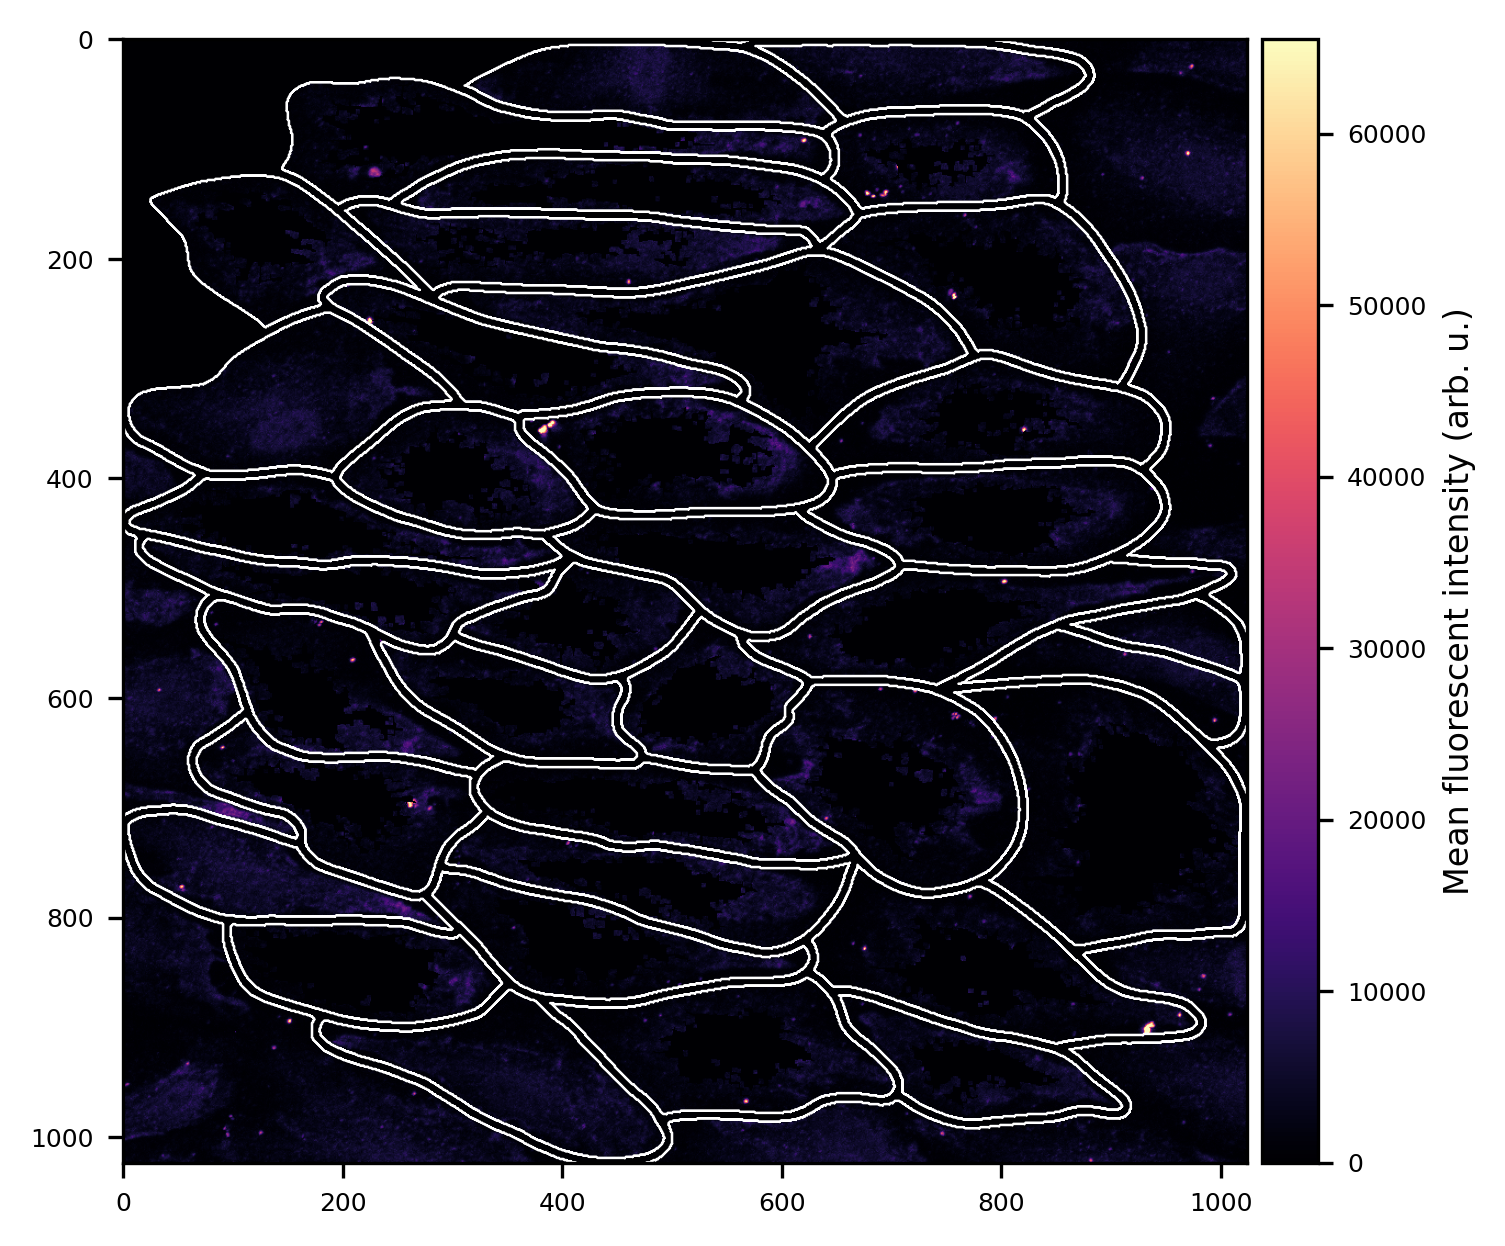

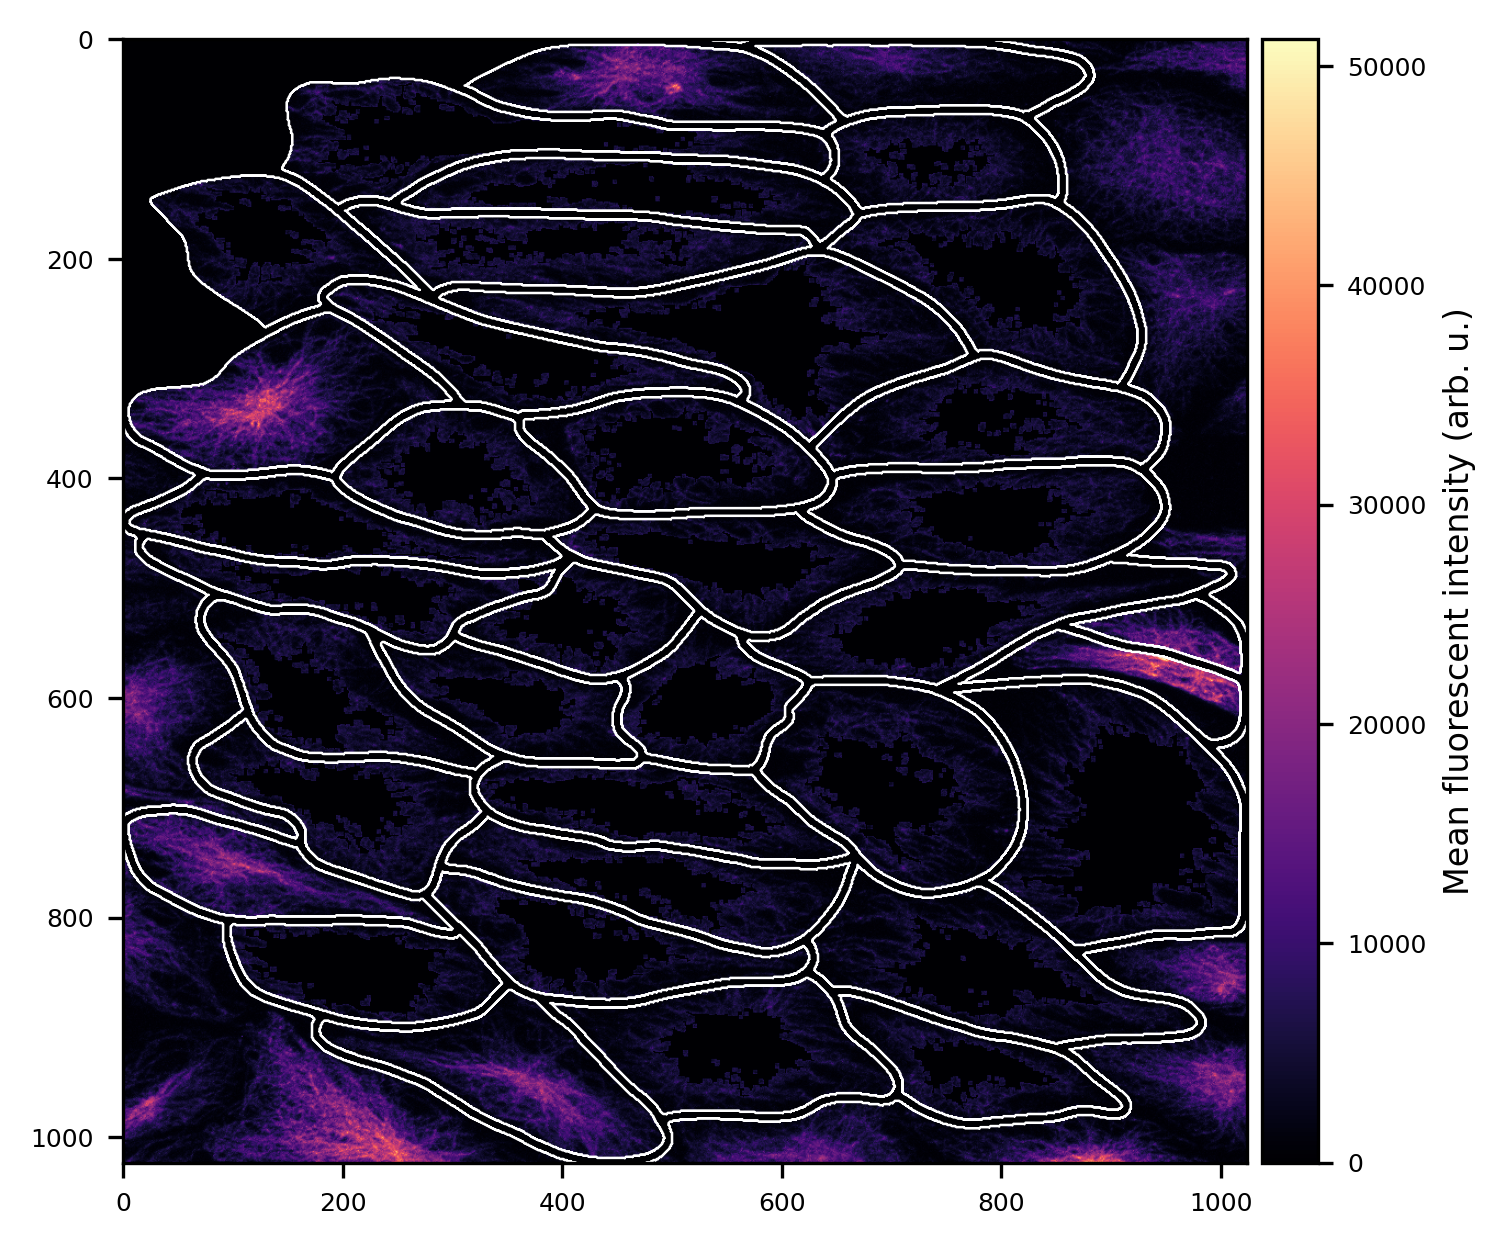

In [25]:
createBoundaryImage(ws_seg, calcium_data, channelInds, channelNames, 1, output_path, [])

(1, 3, 1, 3968, 3832, 1)